# Class: AIT 526 November 27, 2021

Professor: Dr. Duoduo (Lindi) Liao

Team 5:
- Anh "Tim" Hien Bach
- Robert "Robb" Jay Dunlap
- Vishnu Lasya Marthala
- David Earl Swanson


<div class="alert alert-block alert-info">
<b>#### Programming Assignment 3 - QA System</b> Implement a Question Answering (QA) system in Python called qa-system.py. Your system should be able to answer \b Who, What, When and Where \b questions (but not Why or How questions). Your system should handle questions from any domain, and should provide answers in complete sentences that are specific to the question asked. Please do not provide any information beyond what is asked for by the question.

Your system should take an approach similar to that of the AskMSR system, and simply reformulate the question as a series of "answer patterns" that you then search for in Wikipedia, where you are hoping to find an exact match to one of your patterns. For example, suppose the question was "Where is Malosky Stadium?". You could reformulate that question using the answer patterns "Malosky Stadium is located in", "Malosky Stadium is found in" or even "The address of Malosky Stadium is". You should have multiple patterns associated with each possible type of question (Who, What, When, and Where).

Your system only needs to answer questions for which it can find an exact match to at least one of your answer patterns. At this point, you do not need to attempt to construct answers from partial information (but may do so for extra credit). Your program should be able to recognize questions it can't answer and respond appropriately.

You should use existing toolkits to interact with Wikipedia.

Your program should run interactively, and prompt the user for questions until the user says "exit". When your program starts it should output a message with your name and a short description of what the system does (see below). Then, a user should enter their question and the system should respond with an answer that is a complete sentence, and should not contain any information beyond that which is asked by the question. Note that this is not a conversational agent, so your system does not need to remember previous questions or answers, nor does it need to engage in "small talk". You may assume that your user will cooperate and only ask well-formed questions.

You should also keep a log file that records the user’s questions, the searches you actually execute, the raw results you obtain from Wikipedia, and finally the answer you generate. You may also include any additional information in your log file that you might think would be helpful in debugging your program. The name of this log file should be given on the command line.
</div>

### Be sure to comment your code. In particular, explain what words you are spotting for (and why) and what statement forms you are converting into questions (and why). Also make sure your name, class, etc. is clearly included in the comments.

<div class="alert alert-block alert-success">
    <b>Narrative</b> We studied the referenced paper "An Analysis of the AskMSR Question-Answering System" by Brill et al.  Our program was designed to follow their instructions.  We were successful in preprocessing the question into a declarative statement.  Then we used the Wikipedia summary and search routines to gather data on the question.  Wiki is not a very good source of data and therefore the results are less impressive than if we had queried the full web.  We selected 5 questions for each of the Who, What, Where, and When questions from the TREC-9 Question Set.  
    
Our system implements an Ngram tiling system based on the paper's description and other resources found on the web.  This system is not widely used, therefore the references were sparse.  Our system is not full proof.  If performs better on Who questions overall than on others.  The preprocessing of questions does not address all variations of questions.  In the block below, you can see our success measures for reformatting.  WE provided a companion file in Word format that contains the questions, our system's responses, and the correct responses.  As a summary, We were able to get 14 correct answers, 3 answer that are partially correct, meaning they contain the answer but they also contain other information. 2 questions resulted in the code admitting it can't find an answer and there were 11 incorrect answers. 
    
Files accompanying this notebook are:
    1) qa_questions.txt -  List of questions used by the script.
    2) QA_log.txt - Selected outputs from the program as it progresses through processing.
    3) Team 5 Assignment 3 Compiled Questions and Answers.docx - Contains the question, our answer and the correct answer.
  
</div>

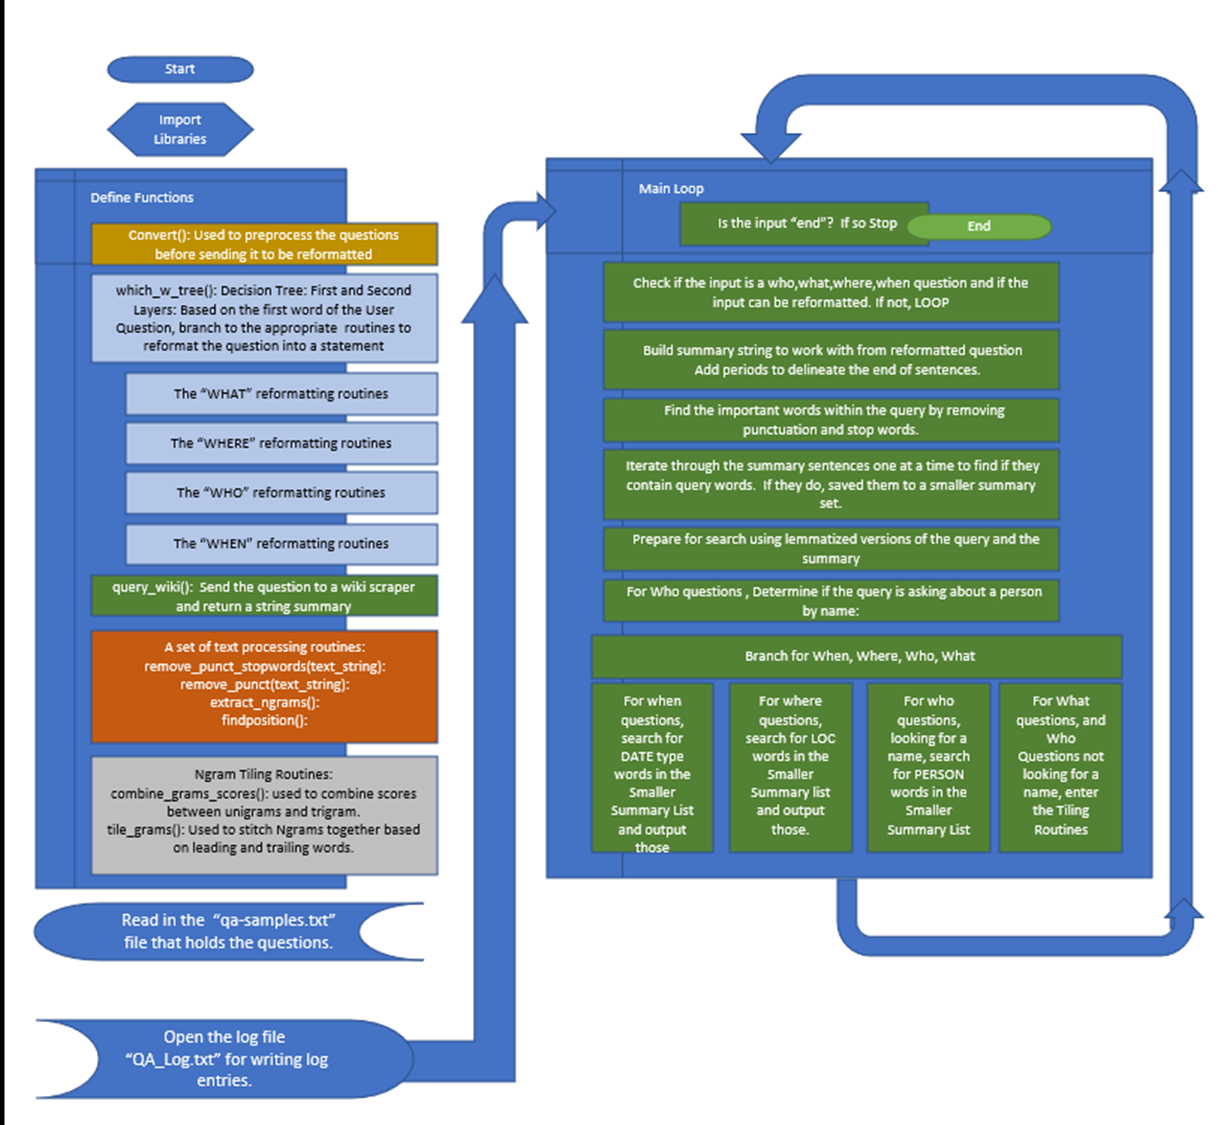

<div class="alert alert-block alert-success">
<b>Question Reformulation Scoring:</b> We used the TREC-9 questions as a test set for developing our system (https://trec.nist.gov/data/qa/T9_QAdata/qa_questions_201-893).
We manually checked the results of our test questions to score how well the question reformulation code worked.

|Type of Question|Precent Correct|
|:---|:---:|
|Who|81%|
|What|42%|
|When|54%|
|Where|89%|

What and When questions generally have more grammatic complexity and therefore much more complicated decision trees to parse and reformulate the questions into answer frameworks.
</div>

Due: November 23, 2021 for Extra Credit.  
Due 11/29 at the latest.

***

In [3]:
import spacy
import warnings
from spacy import displacy
import pandas as pd

import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
import nltk 
import re
from nltk.corpus import wordnet 
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from collections import Counter
from nltk.stem import WordNetLemmatizer

from nltk.probability import FreqDist
import pprint
from pprint import pprint
import wikipedia

import sys
import os
from nltk import pos_tag
from nltk import RegexpParser, RegexpChunkParser
from string import punctuation

In [4]:
nlp = spacy.load('en_core_web_lg')

In [98]:
def convert_question(input_sent):

    # Question preprocessing

    #input_sent = quests_df.iloc[282,1]
    # strip whitespace before and after the input sentence
    input_sent = input_sent.strip()

    # strip common punctuation from the input sentence but leave apostrophes because they are necessary later
    punct_list = ['?','.','!','"']
    for punct in punct_list:
        input_sent = input_sent.replace(punct, '')
        
    # create the spacy object
    doc = nlp(input_sent)
        
    # If any of the 4-W words are contractions then split into the 4W word + is
    if doc[1].text == "'s":
        uncontractionized_sent = doc[0].text + ' is ' + doc[2:].text
        doc = nlp(uncontractionized_sent)

    # number of tokens in the question
    len_sent = len(doc)

    #output_sent,first_word = which_w_tree(doc)
    return which_w_tree(doc)

In [97]:
# 1st layer of the decision tree
def which_w_tree(doc):
    first_word = doc[0].text.lower()
    if first_word == 'what':
        returned_sent = what_tree(doc)
    elif first_word == 'where':
        returned_sent = where_tree(doc)
    elif first_word == 'who':
        returned_sent = who_tree(doc)
    elif first_word == 'when':
        returned_sent = when_tree(doc)
    else:
        return 'Not a Who, What, Where, or When Question',first_word
    
    return returned_sent,first_word

In [ ]:
# 2nd layer decision tree functions 

def what_tree(spacy_obj):
    spacy_obj_pos_after_aux = [x.pos_ for x in spacy_obj[2:]]
    if len(spacy_obj) == 3:
        returned_sent = what_are_three(spacy_obj)
    elif spacy_obj_pos_after_aux[-2] == 'ADP':
        returned_sent = what_is_noun_prep(spacy_obj)
    elif 'VERB' in spacy_obj_pos_after_aux:
        returned_sent = what_buried_verb(spacy_obj)
    else:
        returned_sent = what_is_other(spacy_obj)
    return returned_sent


def where_tree(spacy_obj):
    aux_verb = spacy_obj[1].text.lower()
    if aux_verb == 'do':
        returned_sent = where_do_fall_through(spacy_obj)
    elif aux_verb == 'did':
        if spacy_obj[1].pos_ == 'DT':
            returned_sent = where_did_dt(spacy_obj)
        else:
            returned_sent = where_did_fall_through(spacy_obj)
    elif aux_verb == 'does':
        if spacy_obj[-2].pos_ == 'VERB' and spacy_obj[-1].pos_ == 'ADP':
            returned_sent = where_does_end_ADP(spacy_obj)
        else:
            returned_sent = where_does_fall_through(spacy_obj)
    else:
        spacy_obj_pos_after_aux = [x.pos_ for x in spacy_obj[2:]]
        if spacy_obj_pos_after_aux[-1] == 'VERB':
            returned_sent = where_be_end_verb(spacy_obj)
        elif 'VERB' in spacy_obj_pos_after_aux:
            returned_sent = where_be_split_by_verb(spacy_obj)
        else:
            returned_sent = where_be_fall_through(spacy_obj)
    return returned_sent

# def who_tree(spacy_obj):
#     if spacy_obj[1].text.lower() not in ['is','was','are','were'] and spacy_obj[2].pos_ == 'DET':
#         returned_sent = who_aux_dt(spacy_obj)
#         print('who_tree to who_aux_dt')
#     else:
#         returned_sent = who_fall_through(spacy_obj)
#         print('who_tree to who_fall_through')
#     return returned_sent

def who_tree(spacy_obj):
    if spacy_obj[1].text.lower() not in ['is','was','are','were'] and spacy_obj[1].text[-1].lower() == 's':
        returned_sent = who_not_be_current_tense(spacy_obj)
    elif spacy_obj[1].text.lower() not in ['is','was','are','were']:
        returned_sent = who_aux_dt(spacy_obj)
    else:
        returned_sent = who_fall_through(spacy_obj)
    return returned_sent


def when_tree(spacy_obj):
    # when-sentences that have 'did' as the AUX verb have to have their ending verb converted to 
    # past tense. This is too hard for this project because it would rqeuire a HUGE library to do so.
    if spacy_obj[1].text.lower() == 'did':
        returned_sent = 'NOPE NOPE NOPE'
    elif spacy_obj[-1].pos_ == 'VERB':
        returned_sent = when_last_verb(spacy_obj)
    else:
        returned_sent = when_fall_through(spacy_obj)
    return returned_sent

In [50]:
# functions for rearranging questions that start with "what"

def what_is_other(spacy_obj):
    len_sent = len(spacy_obj)
    returned_sent = str()
    
    for i in range(len_sent-2):
        if i == 0:
            returned_sent = spacy_obj[i+2].text.capitalize() + ' '
        else:
            returned_sent = returned_sent + spacy_obj[i+2].text + ' '
    returned_sent = returned_sent + spacy_obj[1].text + ' '            
    return returned_sent


def what_is_noun_prep(spacy_obj):
    len_sent = len(spacy_obj)
    returned_sent = spacy_obj[2].text.capitalize() + ' '
    
    for i in range(len_sent-3):
        if spacy_obj[i+3].pos_ == 'NOUN' or spacy_obj[i+3].pos_ == 'PROPN' or spacy_obj[i+3].pos_ == 'CONJ' or spacy_obj[i+3].pos_ == 'CCONJ':
            returned_sent = returned_sent + spacy_obj[i+3].text + ' '
        else:
            break
        
    returned_sent = returned_sent + spacy_obj[1].text + ' ' + spacy_obj[i+3:].text          
    return returned_sent


def what_buried_verb(spacy_obj):
    len_sent = len(spacy_obj)
    transfer_portion = str()
    for i in range(len_sent-1):
        if spacy_obj[i+1].pos_ == "VERB" or spacy_obj[i+1].pos_ == "AUX":
            break
        else:
            transfer_portion = transfer_portion + spacy_obj[i+1].text + ' '
            
    returned_sent = spacy_obj[i+2:].text + ' ' + spacy_obj[i+1].text + ' ' + 'a' + ' ' + '*' + ' ' + transfer_portion
    returned_sent = returned_sent.capitalize()
    return returned_sent
    

def what_are_three(spacy_obj):
    return (spacy_obj[2].text.capitalize() + ' ' + spacy_obj[1].text + ' ')



In [51]:
# functions to rearrange questions that start with "where"
# def where_no_verb_after_aux(spacy_obj, len_sent):
#     returned_sent = str()
    
#     for i in range(len_sent-2):
#         if i == 0:
#             returned_sent = spacy_obj[i+2].text.capitalize() + ' '
#         else:
#             returned_sent = returned_sent + spacy_obj[i+2].text + ' '
#     returned_sent = returned_sent + spacy_obj[1].text + ' '  + 'in' + ' '          
    
#     return returned_sent


#### 2nd word - is/are/was/were

######## sent ends in verb
def where_be_end_verb(spacy_obj):
    returned_sent = spacy_obj[2:-1].text + ' ' + spacy_obj[1].text + ' ' + spacy_obj[-1].text + ' in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


######## where be split by verb - AUX ADJ* (NOUN|PROPN)+ ADV* VERB remainder
def where_be_split_by_verb(spacy_obj):
    output_str = str()
    for i in range(len(spacy_obj[2:])):
        if spacy_obj[i+2].pos_ == 'ADV' or spacy_obj[i+2].pos_ == 'VERB':
            break
        else:
            output_str = output_str + spacy_obj[i+2].text + ' '


    for j in range(len(spacy_obj[i:])):
        if spacy_obj[j+i].pos_ == 'VERB':
            verb_locator = j+i
            break

    returned_sent = output_str + spacy_obj[verb_locator + 1:].text + ' ' + spacy_obj[1].text + ' ' + spacy_obj[i+j].text + ' in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


######## where be fall through
def where_be_fall_through(spacy_obj):
    returned_sent = spacy_obj[2:].text + ' ' + spacy_obj[1].text + ' in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


#### 2nd word - did

######## where did dt
def where_did_dt(spacy_obj):
    returned_sent = spacy_obj[2:].text + 'd in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


######## where did fall through
def where_did_fall_through(spacy_obj):
    returned_sent = spacy_obj[2:].text + 'd in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


#### 2nd word - do

######## where do fall through
def where_do_fall_through(spacy_obj):
    returned_sent = spacy_obj[2:].text + ' in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


#### 2nd word - does 

######## where does end ADP
def where_does_end_ADP(spacy_obj):
    len_sent = len(spacy_obj)
    returned_sent = spacy_obj[2].text.capitalize() + ' '
    for i in range(len_sent-3):
        if spacy_obj[i+3].pos_ == 'ADP':
            break
        else:
            returned_sent = returned_sent + spacy_obj[i+3].text
    returned_sent = returned_sent + 's ' + spacy_obj[i+3].text
    return returned_sent


######## where does fall through
def where_does_fall_through(spacy_obj):
    returned_sent = spacy_obj[2:].text + 's in'
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


In [52]:
# functions to rearrange questions that start with "who"

######## who (2nd word is not "be") 2nd word is current tense
def who_not_be_current_tense(spacy_obj):
    returned_sent = spacy_obj[2:].text + ' are ' + spacy_obj[1].text[:-1] + 'ed by '
    return returned_sent 
    

######## who aux dt
def who_aux_dt(spacy_obj):
    returned_sent = spacy_obj[2:].text + ' was ' + spacy_obj[1].text + ' by '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent 


######## who fall through
def who_fall_through(spacy_obj):
    returned_sent = spacy_obj[2:].text + ' ' + spacy_obj[1].text + ' '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


In [53]:
# functions to rearrange questions that start with "when"

######## when did
def when_last_verb(spacy_obj):
    returned_sent = spacy_obj[2:-1].text + ' was ' + spacy_obj[-1].text + ' in '
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent

######## when fall through
def when_fall_through(spacy_obj):
    returned_sent = spacy_obj[2:].text + ' was on ' 
    returned_sent = returned_sent[0].capitalize() + returned_sent[1:]
    return returned_sent


In [99]:
# These functions are used in the query and tiling of Ngrams.
def query_wiki(question):        
    ListofSummaries = ""
    
    # Try to query Wikipedia.  It may not have an answer
    try:
        summary = wikipedia.summary(question, sentences=40).split('. ')
        for sent in summary:
            if sent not in ListofSummaries:
                ListofSummaries = ListofSummaries+sent+'\n'
    except:
        # if the summary doesn't return an answer then use the search features to get other ways to ask the question.
        try:
            search_terms =wikipedia.search(question, results=5)     
            for entry in search_terms:
                try:
                    summary = wikipedia.summary(entry, sentences=5).split('. ')
                    for sent in summary:
                        if sent not in ListofSummaries:
                            ListofSummaries = ListofSummaries+sent+'\n'
                except:
                    continue
        except wikipedia.exceptions.DisambiguationError as e:
            k=1
            
    return ListofSummaries

def remove_punct_stopwords(text_string):
    # Remove punctuation.
    tokenizer = RegexpTokenizer (r'\w+')
    text_string = tokenizer.tokenize(text_string) 
    text = ""
    for word in text_string:
        if word.lower() in stopWords:
            continue
        else:
            text = text+' '+word
    return text

def remove_punct(text_string):
    # Remove punctuation.
    tokenizer = RegexpTokenizer (r'\w+')
    text_string = tokenizer.tokenize(text_string) 
    text = ""
    for word in text_string:
            text = text+' '+word
    return text

def extract_ngrams(data, num):
        n_grams = ngrams(word_tokenize(data.lower()),num)
        return [' '.join(grams) for grams in n_grams]
    
def findposition(word, tuple):
    wordsintuple = tuple.split(' ')
    i = 0
    for wd in wordsintuple:
        i +=1
        if wd == word:
            return i
    return 0 

def combine_grams_scores(frqunigms, frqtrigms):
    Ngram = FreqDist()
    temp = FreqDist()
    #print('Types:',type(frqunigms), type(frqtrigms))
    #print('The unigrams are;',frqunigms)
    for trigrams in frqtrigms:
        wordsintrigrams = trigrams[0].split(' ')
        
        # Search the unigrams for similar entries and add their values to the corresponding trigram.  The delete the unigram.
        b1key = wordsintrigrams[0]
        b2key = wordsintrigrams[1] 
        b3key = wordsintrigrams[2]
        #print('The b-keys are;', b1key, b2key, b3key)
          
        for unigrams in frqunigms:
            unikey = unigrams[0]
            if b1key == unikey or b2key == unikey or b3key == unikey:
                temp[trigrams[0]]=trigrams[1]+unigrams[1]
                #print('\n\nHere is the key, and new value:',trigrams[0],trigrams[1]+unigrams[1])
                Ngram.update(temp)
                temp.clear()
            else:
                temp[trigrams[0]]=trigrams[1]
                #print('\n\nHere is the key, and old value:',trigrams[0],trigrams[1])
                Ngram.update(temp)
                temp.clear()
                                      
    return Ngram

def tile_grams(frqbigms, frqtrigms, query_words):
    Ngram = FreqDist()
    temp = FreqDist()
    for trigrams in frqtrigms:
        wordsintrigrams = trigrams[0].split(' ')

        # Search the unigrams for similar entries and add their values to the corresponding trigram.  The delete the unigram.
        b1key = wordsintrigrams[0]
        b3key = wordsintrigrams[len(wordsintrigrams)-1] 
        
        factor = 1
        for words in query_words:
            if words.text in wordsintrigrams:
                factor = factor*2
        
           
        # Search the bigrams for bigrams entries that end wioth the same word the triograms vbegins with and add the first word to the trigram as the Ngram.      
        for grams in frqbigms:
            newKey = ""
            keysingrams = grams[0].split(' ')
            #print("keysingrams:", keysingrams)
            #print("wordsintrigrams:", wordsintrigrams)

            # If the first word of the trigram is the same as the last word of the bigram, add the bigram to the front of the trigram key and add the values 
            if keysingrams[len(keysingrams)-1] == b1key:
                
                #build a new key for the Ngrams Dict
                for l in range(0,len(keysingrams)):
                    newKey = newKey+' '+keysingrams[l]
                for l in range(1,len(wordsintrigrams)):
                    newKey = newKey+' '+wordsintrigrams[l]
                temp[newKey.strip()]=trigrams[1]*factor+grams[1]
                Ngram.update(temp)
                temp.clear()
                
            # If the last word of the trigramn is that same as the first word of the bigram, add the bigram to the end of the trigram key and add the values 
            elif b3key == keysingrams[0]:
                
                #build a new key for the Ngrams Dict 
                for l in range(0,len(wordsintrigrams)):
                    newKey = newKey+' '+wordsintrigrams[l]
                for l in range(1,len(keysingrams)):
                    newKey = newKey+' '+keysingrams[l]
                temp[newKey.strip()]=trigrams[1]*factor+grams[1]
                Ngram.update(temp)
                temp.clear()
              
            else:
                for l in range(0,len(keysingrams)):
                    newKey = newKey+' '+keysingrams[l]
                #print('New Key in Temp:', newKey, 'trigrams[1]:',trigrams[1])
                temp[newKey.strip()]=trigrams[1]*factor
                Ngram.update(temp)
                temp.clear()
    
        #print(Ngram.keys())

    return Ngram

In [124]:
#Open the list of questions sentence 
with open("qa-samples.txt", "r", encoding="utf8") as input_sentences:
    test_questions_str = input_sentences.readlines()
    test_questions = []
    for item in test_questions_str:
        test_questions.append(item.replace("\n",""))
input_sentences.close

#for input_sent in test_questions:
#    print(input_sent)

<function TextIOWrapper.close()>

In [125]:
# Open the log file for output
lemmatizer = WordNetLemmatizer()
f = open("QA_Log.txt", "w", encoding="utf-8")

# Using the list of test questions loaded above, cycle through each and find an answer.
for input_sent in test_questions:
    
    # If the entry is "End" close the program
    if input_sent.lower() == 'exit':
        break
        
    # Reformat the input from a question to a declaration.        
    query, first_word = convert_question(input_sent)
    if query == 'NOPE NOPE NOPE':
        print('I could not reformat the question for \"'+input_sent+'\"\n')
        continue
    
    # if the entry doesn't start with a "who, what, where, or when" then get another input.
    if query == 'Not a Who, What, Where, or When Question':
        print('\"',input_sent,'\" is',query,'\n')
        continue

    # write to the log file.
    forWriting = '\"'+input_sent+'\" was reformated as '+query+'...'
    print(forWriting)
    f.write(forWriting)

    
    # Build summary string to work with from reformated question
    # Add periods to delineate the end of sentences.
    ListofSummaries=""
    for sent in query_wiki(query).split('\n'):
        if sent[0:-1] == '.':
            ListofSummaries=ListofSummaries+sent+' '
        else:
            ListofSummaries=ListofSummaries+sent+'. '            
            
    # write to the log file.            
    forWriting = ListofSummaries+'\n\n' 
    #print(forWriting)
    f.write(forWriting)

    # Find the important words within the query by removing punctuation and stop words.
    refined_doc_query = nlp(remove_punct_stopwords(query).strip())

    # Using the refined_doc_query words, only take the sentences in the summary that mention these words.
    doc_summary = nlp(ListofSummaries)
    warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)
    SmallerListofSummaries = ""
    
    #Iterate through the summary sentences one at a time to find if they contain query words
    for sent in doc_summary.sents: 
        #IF the query word is in the sentence, add it to the small summary string.
        for token in sent:
            Sentence_already_added = False # We only need one hit to add it to the string - set a flag
            for query_word in refined_doc_query:
                
                # Make sure that any lemma of the query words are identified
                if query_word.lemma_ in sent.text:
                    SmallerListofSummaries = SmallerListofSummaries+sent.text+'. '
                    Sentence_already_added = True # Change the flag if the sentence was added
                    forWriting = '\n'+query_word.text+'  --->  '+sent.text+'\n\n' 
                    f.write(forWriting)                   
            if Sentence_already_added == True:
                    break

    # write to the log file.                    
    forWriting = 'and converted it to a smaller summary result based on the key word(s):'
    # Iterate through the doc_query words for printing and writing
    for ent in refined_doc_query:
        forWriting = forWriting+' '+str(ent.text) 
    forWriting = forWriting+'\n\n'
    #print(forWriting)
    f.write(forWriting)
    forWriting = '\n'+SmallerListofSummaries+'\n\n' 
    f.write(forWriting)

    # Prepare for search using lemmatized versions of the query and the summary
    keyWords = ' '.join([lemmatizer.lemmatize(words) for words in word_tokenize(refined_doc_query.text)])
    SummaryWords = ' '.join([lemmatizer.lemmatize(words) for words in word_tokenize(SmallerListofSummaries)])
    doc = nlp(SummaryWords)
            

    #Determine if the query is asking about a person by name:
    PERSON_NAME = False # Assume we are looking for a person's description. Like: Who is Johnny?
    for ent in refined_doc_query.ents:
        if ent.label_ == 'PERSON':
            PERSON_NAME = True # Flag says we are looking for an answer that is a Proper Noun or NAME.  Like: Who is the President?

    # If the query is looking for date           
    if first_word == 'when':
        c_DATES = 0
        date_list = []
        for ent in doc.ents:
            if ent.label_ == 'DATE':
                c_DATES +=1
                date_list.append(ent.text)

                #Write to log file
                forWriting = '\n'+ent.text+'   '+ent.label_+'\n\n' 
                f.write(forWriting)

        date_set = set(date_list)

        if c_DATES == 0:
            answer_query = 'I could not find the answer for \"'+input_sent+'\"'
        else:
            c_count = 0
            answer_query = query
            for ent in date_set:
                c_count += 1
                if len(date_set) == 1:
                    answer_query = answer_query+ent+"."    
                elif c_count == len(date_set):
                        answer_query = answer_query+'and '+ ent+'.'
                else:
                    answer_query = answer_query+ent+', '
 
    # If the query is looking for date           
    elif first_word == 'where':
        c_DATES = 0
        date_list = []
        for ent in doc.ents:
            if ent.label_ == 'LOC':
                c_DATES +=1
                date_list.append(ent.text)

                #Write to log file
                forWriting = '\n'+ent.text+'   '+ent.label_+'\n\n' 
                f.write(forWriting)

        date_set = set(date_list)

        if c_DATES == 0:
            answer_query = 'I could not find the answer for \"'+input_sent+'\"'
        else:
            c_count = 0
            answer_query = query
            for ent in date_set:
                c_count += 1
                if len(date_set) == 1:
                    answer_query = answer_query+ent+"."    
                elif c_count == len(date_set):
                        answer_query = answer_query+'and '+ ent+'.'
                else:
                    answer_query = answer_query+ent+', '
            
            
    # If the query is looking for a person's Proper Noun name, follow this branch            
    elif PERSON_NAME == False and first_word == 'who':
        c_PERSONS = 0
        persons_list = []
        for ent in doc.ents:
            if ent.label_ == 'PERSON':
                c_PERSONS +=1
                persons_list.append(ent.text)

                #Write to log file
                forWriting = '\n'+ent.text+'   '+ent.label_+'\n\n' 
                f.write(forWriting)

        person_set = set(persons_list)

        if c_PERSONS == 0:
            answer_query = 'I could not find the answer for \"'+input_sent+'\"'
        else:
            c_count = 0
            answer_query = query
            for ent in person_set:
                c_count += 1
                if len(person_set) == 1:
                    answer_query = answer_query+ent+"."    
                elif c_count == len(person_set):
                        answer_query = answer_query+'and '+ ent+'.'
                else:
                    answer_query = answer_query+ent+', '

    else:
        # Build lists of Ngrams (1, 2, 3).  Created sorted lists in reserve order.
        LemmaofSummaries = keyWords +'. '+SummaryWords

        unigrams = extract_ngrams(remove_punct_stopwords(LemmaofSummaries), 1)
        Frequnigrams = FreqDist(unigrams)
        Frequnigrams_sorted=sorted(Frequnigrams.items(), key=lambda x:x[1], reverse=True)

        bigrams = extract_ngrams(remove_punct(SmallerListofSummaries), 2)
        Freqbigrams = FreqDist(bigrams)
        Freqbigrams_sorted=sorted(Freqbigrams.items(), key=lambda x:x[1], reverse=True)

        trigrams = extract_ngrams(remove_punct(SmallerListofSummaries), 3)
        Freqtrigrams = FreqDist(trigrams)
        Freqtrigrams_sorted=sorted(Freqtrigrams.items(), key=lambda x:x[1], reverse=True)

        # Eliminate the unigrams which are in the trigrams by adding their frequencies to the corresponding trigrams.
        trigrams = combine_grams_scores(Frequnigrams_sorted, Freqtrigrams_sorted)
        Freqtrigrams = FreqDist(trigrams)
        Freqtrigrams_sorted=sorted(Freqtrigrams.items(), key=lambda x:x[1], reverse=True)

        # Send the sorted bigrams and the new trigrams to be tiled.
        #print(Freqtrigrams_sorted,'\n')
        Ngrams = tile_grams(Freqbigrams_sorted, Freqtrigrams_sorted, refined_doc_query)
        FreqNgrams_sorted=sorted(Ngrams.items(), key=lambda x:x[1], reverse=True) 

        # Send the higher order grams and the trigrams to be tiled.
        N1grams = tile_grams(Freqtrigrams_sorted, FreqNgrams_sorted, refined_doc_query)
        FreqN1grams_sorted=sorted(N1grams.items(), key=lambda x:x[1], reverse=True)

        # Send the higher order grams and the trigrams to be tiled.
        #print(FreqN1grams_sorted,'\n')
        N2grams = tile_grams(FreqNgrams_sorted[0:100], FreqN1grams_sorted[0:100], refined_doc_query)
        FreqN2grams_sorted=sorted(N2grams.items(), key=lambda x:x[1], reverse=True)

        # Send the higher order grams and the trigrams to be tiled.
        #print(FreqN2grams_sorted,'\n')
        N3grams = tile_grams(FreqN1grams_sorted[0:100], FreqN2grams_sorted[0:100], refined_doc_query)
        FreqN3grams_sorted=sorted(N3grams.items(), key=lambda x:x[1], reverse=True) 

        

        #print('Tiled Grams:',FreqN3grams_sorted[0:100])
        try:
            target = str(FreqN3grams_sorted[0][0])
            #print(target,'\n')
        except:
            try:
                target = str(FreqN2grams_sorted[0][0])
            except:
                target = str(FreqN1grams_sorted[0][0])

        sent = SmallerListofSummaries.split('. ')

        for st in sent:
            ST = remove_punct(st)
            s_count = 0
            if target in ST and s_count == 0:
                answer_query = query+'\" '+st+'\"'
                s_count = 1
                
                
        if answer_query == 'TBD':
            sent = ListofSummaries.split('. ')
            for st in sent:
                ST = remove_punct(st)
                s_count = 0
                if target in ST and s_count == 0:
                    answer_query = query+'\" '+st+'\"'
                    s_count = 1
                    
        if answer_query == 'TBD':
            answer_query = 'I could not find the answer for \"'+input_sent+'\"'
          
    # Write to log file
    ToBeWritten = answer_query+'\n\n'
    print('      ',ToBeWritten)    
    f.write(ToBeWritten)
    answer_query = "TBD"
f.close()
print('Done')


" Does the Sun rise from West to East? " is Not a Who, What, Where, or When Question 

"Who invented the paper clip?" was reformated as The paper clip was invented by ...
       The paper clip was invented by Gem, and Samuel B. Fay.


"Who was the architect of Central Park?" was reformated as The architect of Central Park was ...
       The architect of Central Park was Calvert Vaux, Robert Moses, and Frederick Law Olmsted.


"Who is the prime minister of Australia?" was reformated as The prime minister of Australia is ...
       The prime minister of Australia is Scott Morrison.


"Who invented the radio?" was reformated as The radio was invented by ...
       The radio was invented by Guglielmo Marconi 's, and Heinrich Rudolf Hertz.


"Who was the author of the book about computer hackers called "The Cuckoo's Egg: Tracking a Spy Through the Maze of Computer Espionage"?" was reformated as The author of the book about computer hackers called The Cuckoo's Egg: Tracking a Spy Through the